In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy

Welcome to JupyROOT 6.30/06


In [2]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


In [3]:
channel = 8

In [4]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [5]:
PATH = f'../Dati/Dati_belli/Ch{channel}/Run_ch{channel}_Cs.root'
#PATH = '../Dati/21-03/Run_ch' + str(channel) + '_Cs_Measurements_Only_3_21_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare


#noise_file = '../Dati/21-03/Run_ch' + str(channel) + '_X_Measurements_Only_3_21_2024_0000.root'  #File di rumore di riferimento per il canale
noise_file = f'../Dati/Dati_belli/Ch{channel}/Run_ch{channel}_X.root'
RunNoise = uproot.open(noise_file)  #Apertura rumore

FileNotFoundError: [Errno 2] No such file or directory: '/Applications/Coding/Sfera/Sfera/Jupyter/Fit_completi/../Dati/Dati_belli/Ch8/Run_ch8_Cs.root'

In [ ]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

In [ ]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 6 = 850959
#Noise ripulita su ch 6 = 219968


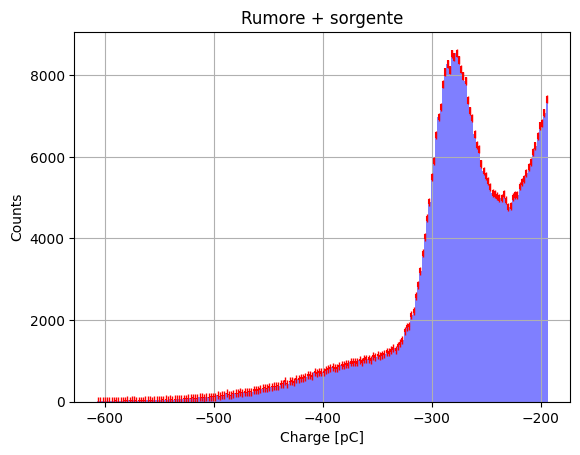

In [ ]:
Nbin = 200
bin_lims = [int(Nbin * 40 / 100), int(Nbin * 83/ 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


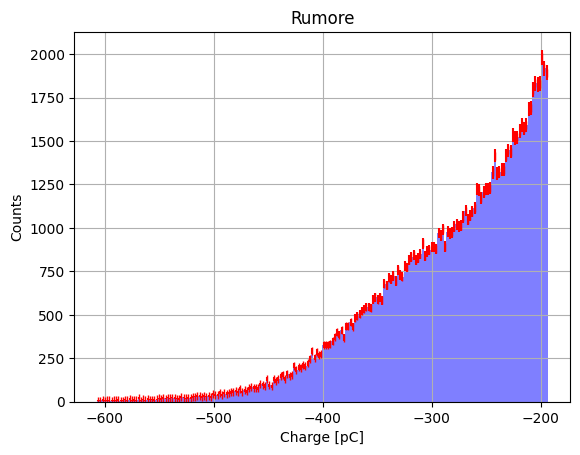

104017.0

In [ ]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()


In [ ]:
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

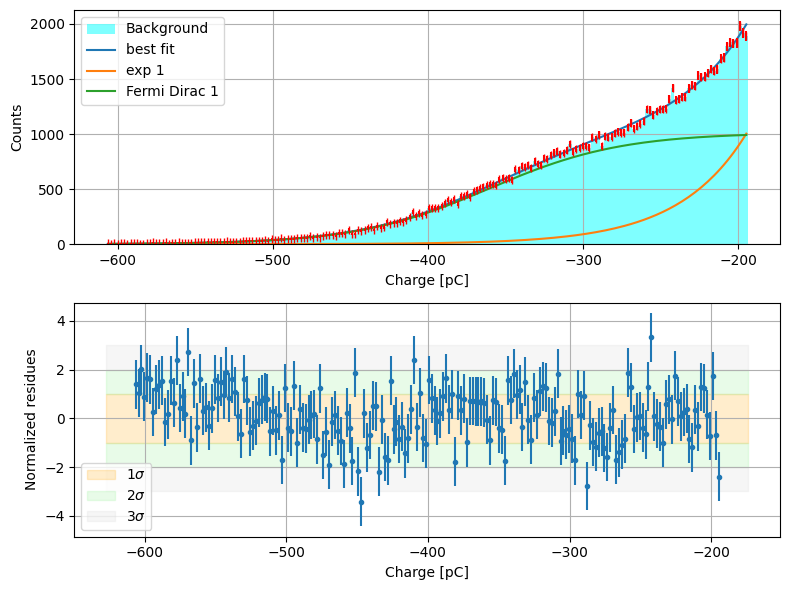

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 75
    # data points      = 200
    # variables        = 5
    chi-square         = 247.487769
    reduced chi-square = 1.26916804
    Akaike info crit   = 52.6087589
    Bayesian info crit = 69.1003457
    R-squared          = 0.99999589
[[Variables]]
    e1_amplitude:  85756.3856 +/- 36143.7125 (42.15%) (init = 66438.88)
    e1_decay:     -43.7608448 +/- 4.43980242 (10.15%) (init = -67.85096)
    s1_amplitude:  1012.69527 +/- 53.2965217 (5.26%) (init = 1976)
    s1_center:    -360.450425 +/- 3.18951866 (0.88%) (init = -400.4838)
    s1_sigma:      42.7765303 +/- 0.71223008 (1.67%) (init = 58.81673)
    g1_amplitude:  0 (fixed)
    g1_center:    -320 (fixed)
    g1_sigma:      25 (fixed)
    g1_fwhm:       58.8705000 +/- 0.00000000 (0.00

In [ ]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide



 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(binN, x=centersN))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   #Indovina i parametri della prima gaussiana
#params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
#params.update(fd1.make_params(amplitude = 0, center = -200, kt = -15))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))

params["g1_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g1_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g1_sigma"].vary = False
params["s2_amplitude"].vary = False
params["s2_center"].vary = False
params["s2_sigma"].vary = False

model = exp1 + gauss1 + sigmoid1 + sigmoid2  #Per ora non usiamo la Fermi Dirac at all

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['s1_'], label='Fermi Dirac 1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|')
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [ ]:
N_params = result.params
params.update(N_params)
params

name,value,standard error,relative error,initial value,min,max,vary,expression
e1_amplitude,85756.3856,36143.7125,(42.15%),66438.8790886584,-inf,inf,True,
e1_decay,-43.7608448,4.43980242,(10.15%),-67.85096078649492,-inf,inf,True,
s1_amplitude,1012.69527,53.2965217,(5.26%),1976.0,-inf,inf,True,
s1_center,-360.450425,3.18951866,(0.88%),-400.4838218688965,-inf,inf,True,
s1_sigma,42.7765303,0.71223008,(1.67%),58.81672995431082,0.00000000,inf,True,
g1_amplitude,0.00000000,0.00000000,,0.0,-inf,inf,False,
g1_center,-320.000000,0.00000000,(0.00%),-320.0,-inf,inf,False,
g1_sigma,25.0000000,0.00000000,(0.00%),25.0,0.00000000,inf,False,
g1_fwhm,58.8705000,0.00000000,(0.00%),58.87050000000001,-inf,inf,False,2.3548200*g1_sigma
g1_height,0.00000000,0.00000000,,0.0,-inf,inf,False,"0.3989423*g1_amplitude/max(1e-15, g1_sigma)"


In [ ]:
#print(result.uvars["e1_amplitude"].s, result.uvars["e1_amplitude"].n)
#print(result.uvars.values())
fit_errs = [getattr(value, 's') for value in result.uvars.values()]
print(fit_errs)

[36143.71248207239, 4.439802418174239, 53.296521652478155, 3.1895186637637445, 0.7122300764492125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [11]:
N_comp_ratio = float(params["e1_amplitude"].value / params["s1_amplitude"].value)
print(N_comp_ratio)

NameError: name 'params' is not defined

In [6]:
from uncertainties import ufloat

def to_ufloat(var):
    return ufloat(var.n, var.s)


print(f'{result.uvars["e1_amplitude"]:.3f}')
print(f'{result.uvars["s1_amplitude"]:.3f}')
def rapp(x, y):
    return x / y
print(f'{result.uvars["e1_amplitude"] / result.uvars["s1_amplitude"]:.8f}')
print(f'{rapp(result.uvars["e1_amplitude"], result.uvars["s1_amplitude"]):.8f}')
print(f'{to_ufloat(result.uvars["e1_amplitude"]) / to_ufloat(result.uvars["s1_amplitude"]):.8f}')

NameError: name 'result' is not defined

In [7]:

#ufloat(value.nominal_value, value.std_dev)

print(type(result.uvars["e1_amplitude"]))
print(type(to_ufloat(result.uvars["e1_amplitude"])))

NameError: name 'result' is not defined

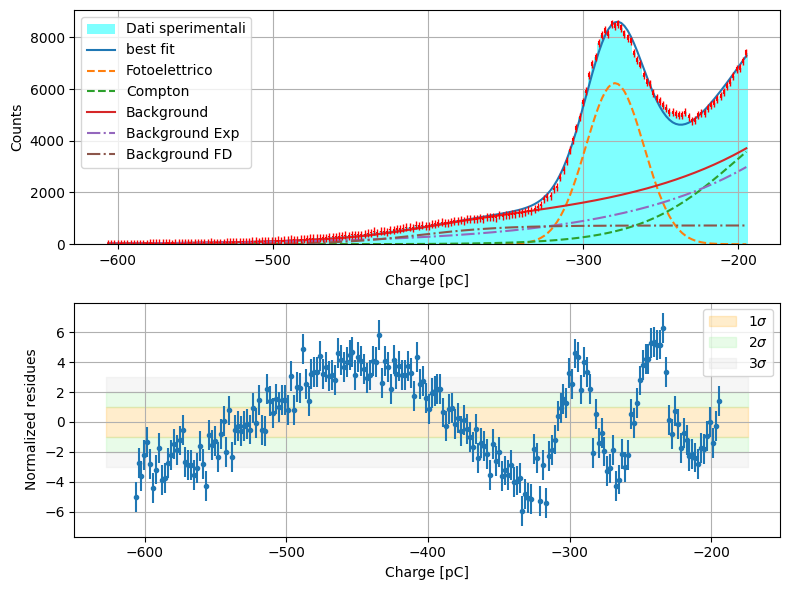

In [ ]:
params.update(N_params)


params["s1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima Fermi Dirac
params["s1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False

params["s2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["s2_center"].vary = True
params["s2_sigma"].vary = True
params["g1_amplitude"].vary = True
params["g1_center"].vary = True
params["g1_sigma"].vary = True

params.add("ratio", value = N_comp_ratio)
#params.add("e1_amplitude", expr = 's1_amplitude * ratio')
params["e1_amplitude"].expr = 's1_amplitude * ratio'
params["e1_amplitude"].vary = False
params["ratio"].vary = False
params["s1_amplitude"].value = 1000

'''
params["g1_amplitude"].value = 900000    #Parametri da aggiustare to make the magic happen
params["g1_center"].min = -320          #Si possono, se serve, specificare canale per canale
params["g1_center"].max = -230
params["g1_center"].set(value = -300)
params["g1_sigma"].set(value = 15)

params["s2_amplitude"].set(value = 30)
params["s2_center"].set(value = -175)
params["s2_sigma"].set(value = 5)
params["s2_center"].min = -200
params["s2_center"].max = -100

params.update(params)


params["ratio"].value = 37.92318629865847
params["e1_amplitude"].value = 4753.98568
params["e1_decay"].value = -87.6989345
params["s1_center"].value = -404.501222
params["s1_sigma"].value = 26.6227556
'''

params.add("ratio", value = 26.987002530194488)
#params.add("e1_amplitude", expr = 's1_amplitude * ratio')
params["e1_amplitude"].expr = 's1_amplitude * ratio'
params["e1_amplitude"].vary = False
params["ratio"].vary = False
params["s1_amplitude"].value = 1000


params["g1_amplitude"].value = 900000    #Parametri da aggiustare to make the magic happen
params["g1_center"].min = -320          #Si possono, se serve, specificare canale per canale
params["g1_center"].max = -230
params["g1_center"].set(value = -300)
params["g1_sigma"].set(value = 15)

params["s2_amplitude"].set(value = 30)
params["s2_center"].set(value = -175)
params["s2_sigma"].set(value = 5)
params["s2_center"].min = -200
params["s2_center"].max = -100

params.update(params)


params["ratio"].value = 26.987002530194488
params["e1_amplitude"].value = 8107.195996702572
params["e1_decay"].value = -85.85438088148673
params["s1_center"].value =  -394.0780331034476
params["s1_sigma"].value = 23.898908796533565



# Fit the model to the data
result = model.fit(binCs, params, x = centersCs, weights = 1 / errCs)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersCs, result.best_fit, label='best fit')
ax1.plot(centersCs, comps['g1_'], label='Fotoelettrico', ls = "--")
ax1.plot(centersCs, comps['s2_'], label='Compton', ls = "--")

ax1.plot(centersCs, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centersCs, comps['e1_'], label='Background Exp', ls = "-.")
ax1.plot(centersCs, comps['s1_'], label='Background FD', ls = "-.")




ax1.legend()
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
ax1.grid()

residueCs = binCs - result.best_fit
norm_resCs = residueCs / errCs

ax2.errorbar(centersCs, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
#print(result.fit_report())



In [8]:
print(result.fit_report())

NameError: name 'result' is not defined

In [9]:
params.update(result.params)

params["e1_amplitude"].value / params["s1_amplitude"].value

NameError: name 'params' is not defined

In [10]:
from uncertainties import ufloat



x = ufloat(10, 0.1)  # Value = 10, Uncertainty = 0.1
y = ufloat(5, 0.05)  # Value = 5, Uncertainty = 0.05

# Perform arithmetic operations
z = x + y
print("Sum:", z)

# Propagate uncertainties
result = z ** 2
print("Result:", result)

Sum: 15.00+/-0.11
Result: 225.0+/-3.4


<Figure size 640x480 with 0 Axes>

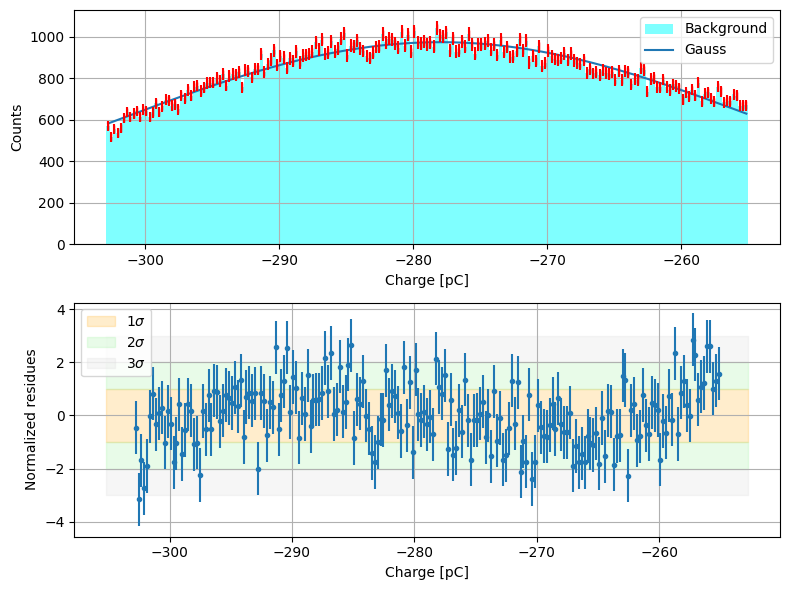

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 201
    # variables        = 3
    chi-square         = 271.001522
    reduced chi-square = 1.36869456
    Akaike info crit   = 66.0627253
    Bayesian info crit = 75.9726401
    R-squared          = 0.99990578
[[Variables]]
    g3_amplitude:  59665.0384 +/- 483.142271 (0.81%) (init = 26360)
    g3_center:    -277.970332 +/- 0.13311242 (0.05%) (init = -278.2343)
    g3_sigma:      24.4401562 +/- 0.25695820 (1.05%) (init = 16.67299)
    g3_fwhm:       57.5521677 +/- 0.60509032 (1.05%) == '2.3548200*g3_sigma'
    g3_height:     973.926182 +/- 3.98877311 (0.41%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9358
    C(g3_amplitude, g3_center) = +0.1643
    C(g3_center, g3_sigma)     = +0.1553


In [302]:
Nbin_gauss = 201
bin_lims_gauss = [int(Nbin_gauss * 72 / 100), int(Nbin_gauss * 77/ 100)] #Scelgo gli estremi
_, edges_g, _ = plt.hist(chargeCs, bins = Nbin_gauss, color = "r")
plt.clf()
lims_gauss = [edges_g[bin_lims_gauss[0]], edges_g[bin_lims_gauss[1]]]
binCs_gauss, edgesCs_gauss, _ = plt.hist(chargeCs, bins = Nbin_gauss, range = lims_gauss, color = "b", alpha = 0.5)
centersCs_gauss = np.convolve(edgesCs_gauss, [0.5, 0.5], "valid")
errCs_gauss = np.sqrt(binCs_gauss)
plt.clf()

gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(binCs_gauss, x=centersCs_gauss)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

# Fit the model to the data
result2 = model2.fit(binCs_gauss, params2, x = centersCs_gauss, weights = 1 / errCs_gauss, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin_gauss, range = lims_gauss, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersCs_gauss, comps['g3_'], label='Gauss')


ax1.legend()
ax1.errorbar(centersCs_gauss, binCs_gauss, errCs_gauss, color = "red", fmt='|')
ax1.grid()

residueGauss = binCs_gauss - result2.best_fit
norm_res_gauss = residueGauss / errCs_gauss

ax2.errorbar(centersCs_gauss, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result2.fit_report())